In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from IPython import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

In [3]:
import numpy as np
import math
import random

In [4]:
import time

In [5]:
def show_state(env, episode,step, info=""):
    plt.figure(99999,figsize=[8,6])
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("episode: {} step: {} ".format(episode,step))
    #plt.title("%s | Step: %d %s" % (env._spec.id,step, info))
    plt.axis('off')

    display.clear_output(wait=True)
    display.display(plt.gcf())

In [6]:
import gym

In [7]:
use_cuda = torch.cuda.is_available()
device=torch.device("cuda:4" if use_cuda else "cpu")

In [8]:
###### PARAMS ######
learning_rate = 0.01
num_episodes = 10000
gamma=0.99
#gamma=0.85
egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 500

report_interval=10

score_to_solve = 195

hidden_layer_size=64

replay_memory_size=500000

batch_size=32

update_target_frequency = 1000

clip_error=False

double_dqn=True

In [9]:
env = gym.make('CartPole-v1')

In [10]:
#env = gym.wrappers.Monitor(env, '../mp4/sandbox10',video_callable=lambda episode_id: True,force=True)
#env = gym.wrappers.Monitor(env, '../mp4/cartpole-5',video_callable=lambda episode_id: episode_id%10==0)

In [11]:
number_of_inputs=env.observation_space.shape[0]
number_of_outputs=env.action_space.n

In [12]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
              math.exp(-1. * steps_done / egreedy_decay )
    return epsilon

In [13]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity=capacity
        self.memory=[]
        self.position=0
        
    
    def push(self, state,
             action, new_state,
             reward, done):
        
            transition=(state,action,new_state,reward,done)
            
            if self.position>=len(self.memory):
                self.memory.append(transition)
            else:
                self.memory[self.position]=transition
                
            self.position=(self.position+1)%self.capacity
        
    
    def sample(self,batch_size):
        return zip(*random.sample(self.memory, batch_size))
    
    def __len__(self):
        return len(self.memory)
    

In [14]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(number_of_inputs,hidden_layer_size)
        self.linear2 = nn.Linear(hidden_layer_size,number_of_outputs)
        
        self.activation=nn.Tanh()
        
    def forward(self, x):
        output1 = self.linear1(x)
        output1 = self.activation(output1)
        output2 = self.linear2(output1)
        
        return output2

In [15]:
class QNet_Agent():
    def __init__(self):
        
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)
        
        self.loss_function = nn.MSELoss()
        self.optimizer = optim.Adam(params=self.nn.parameters(), lr=learning_rate)
        
        self.update_target_counter = 0
        
    def select_action(self,state,epsilon):
        
        random_for_egreedy=torch.rand(1).item()
        
        if random_for_egreedy>epsilon:
            self.nn.eval()
            with torch.no_grad():
                state=torch.Tensor(state).to(device)
                predicted_value_from_nn=self.nn(state)
                action=torch.argmax(predicted_value_from_nn).item()
        else:
            action=env.action_space.sample()
                
                
        return action
    
    def optimize(self):
        
        if len(memory)<batch_size:
            return
        
        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state=torch.Tensor(state).to(device)
        new_state=torch.Tensor(new_state).to(device)
        reward=torch.Tensor(reward).to(device)
        
        #the view call below is to transform into column vector
        #so that it can be used in the gather call
        #i.e. we will use it to pick out from the computed value
        #tensor only values indexed by selected action
        action=(torch.Tensor(action).view(-1,1).long()).to(device)
        #print('action: ')
        #print(action)
        #print('contiguous?', action.is_contiguous())
        done=torch.Tensor(done).to(device)
        
        #print('shape of: state, new state, reward, action, done:')
        #print(state.shape)
        #print(new_state.shape)
        #print(reward.shape)
        #print(action.shape)
        #print(done.shape)
        
        
        self.nn.eval()
        self.target_nn.eval()
            
            
        if double_dqn:
            #print('in double DQN')
            new_state_values_from_nn=self.nn(new_state).detach()
            #print('new_state_values_from_nn shape {} and value:'.format(new_state_values_from_nn.shape))
            #print(new_state_values_from_nn)
            max_new_state_indexes=torch.max(new_state_values_from_nn,dim=1)[1].view(-1,1)
            #print('max_new_state_indexes shape {} and value:'.format(max_new_state_indexes.shape))
            #print(max_new_state_indexes)
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value:'.format(new_state_values.shape))
            #print(new_state_values)
            max_new_state_values=torch.gather(new_state_values,1,max_new_state_indexes).squeeze()
            #print('max_new_state_values shape {} and value:'.format(max_new_state_values.shape))
            #print(max_new_state_values)
        else:
            #print('in regular DQN')
            new_state_values=self.target_nn(new_state).detach()
            #print('new_state_values shape {} and value'.format(new_state_values.shape))
            #print(new_state_values)
        
            max_new_state_values=torch.max(new_state_values,dim=1)[0]
            #print('max_new_state_values shape {} and value'.format(max_new_state_values.shape))
            #print(max_new_state_values)
            
        target_value=(reward + (1-done)*gamma*max_new_state_values).view(-1,1)
        
        #print('shape of: target_value')
        #print(target_value.shape)
        self.nn.train()
        
        #this will select only the values of the desired actions
        predicted_value=torch.gather(self.nn(state),1,action)
        #print('shape of: predicted_value')
        #print(predicted_value.shape)
        
        
        loss=self.loss_function(predicted_value,target_value)
        self.optimizer.zero_grad()
        loss.backward()
        
        if clip_error:
            for param in self.nn.parameters():
                param.grad.clamp_(-1.0,1.0)
        
        self.optimizer.step()
        
        if self.update_target_counter % update_target_frequency == 0:
            #print("***********************")
            #print("UPDATING TARGET NETWORK")
            #print("update counter: {}".format(self.update_target_counter))
            #print("***********************")
            self.target_nn.load_state_dict(self.nn.state_dict())
        
        self.update_target_counter+=1
        

In [16]:
memory=ExperienceReplay(replay_memory_size)

In [17]:
qnet_agent=QNet_Agent()

In [18]:
seed_value=23
env.seed(seed_value)
torch.manual_seed(seed_value)
random.seed(seed_value)

In [19]:
%%time

steps_total=np.full([num_episodes],-999,dtype=np.int32)

frames_total=0

solved_after = 0
solved = False

start_time = time.time()

for i_episode in range(num_episodes):
    
    state = env.reset()
    #for step in range(100):
    step=0
    while True:
        
        step+=1
        frames_total += 1
        
        epsilon=calculate_epsilon(frames_total)
        
        #action=env.action_space.sample()
        action=qnet_agent.select_action(state,epsilon)
        
        new_state, reward, done, info = env.step(action)
        memory.push(state, action, new_state,
                     reward, done)
        
        qnet_agent.optimize()
        
        state=new_state
        
        if done:
            steps_total[i_episode]=step
            
            if i_episode>100:
                mean_reward_100 = np.sum(steps_total[i_episode-100:i_episode])/100
            
                if (mean_reward_100 > score_to_solve and solved == False):
                    print("SOLVED! After %i episodes " % i_episode)
                    solved_after = i_episode
                    solved = True
            
            if (i_episode % report_interval == 0 and i_episode>1):
                print("**** Episode  {} **** ".format(i_episode))
                recent_avg_reward=np.average(steps_total[i_episode-report_interval:i_episode])
                print("Recent average reward: {}".format(recent_avg_reward))
                if i_episode>100:
                    print("Reward over last 100: {}".format(mean_reward_100))
                full_avg_so_far=np.average(steps_total[:i_episode])
                print("Average over all episodes so far: {}".format(full_avg_so_far))
                print("epsilon: {}".format(epsilon))
            
                #print("Episode {} finished after: {}".format(i_episode,step))
            break
            
if solved:
    print("Solved after %i episodes" % solved_after)
        

**** Episode  10 **** 
Recent average reward: 17.3
Average over all episodes so far: 17.3
epsilon: 0.6272174930766827
**** Episode  20 **** 
Recent average reward: 16.2
Average over all episodes so far: 16.75
epsilon: 0.4458165782413052
**** Episode  30 **** 
Recent average reward: 21.4
Average over all episodes so far: 18.3
epsilon: 0.2998088195711187
**** Episode  40 **** 
Recent average reward: 21.7
Average over all episodes so far: 19.15
epsilon: 0.19295156811891478
**** Episode  50 **** 
Recent average reward: 16.3
Average over all episodes so far: 18.58
epsilon: 0.1423197659857774
**** Episode  60 **** 
Recent average reward: 16.8
Average over all episodes so far: 18.283333333333335
epsilon: 0.10724382289832313
**** Episode  70 **** 
Recent average reward: 17.8
Average over all episodes so far: 18.214285714285715
epsilon: 0.07690150497203253
**** Episode  80 **** 
Recent average reward: 18.5
Average over all episodes so far: 18.25
epsilon: 0.05705049857713183
**** Episode  90 ***

**** Episode  580 **** 
Recent average reward: 263.7
Reward over last 100: 176.28
Average over all episodes so far: 120.85
epsilon: 0.01
**** Episode  590 **** 
Recent average reward: 246.1
Reward over last 100: 189.67
Average over all episodes so far: 122.9728813559322
epsilon: 0.01
**** Episode  600 **** 
Recent average reward: 163.3
Reward over last 100: 193.21
Average over all episodes so far: 123.645
epsilon: 0.01
SOLVED! After 604 episodes 
**** Episode  610 **** 
Recent average reward: 191.8
Reward over last 100: 196.78
Average over all episodes so far: 124.76229508196721
epsilon: 0.01
**** Episode  620 **** 
Recent average reward: 170.4
Reward over last 100: 194.66
Average over all episodes so far: 125.4983870967742
epsilon: 0.01
**** Episode  630 **** 
Recent average reward: 223.9
Reward over last 100: 197.66
Average over all episodes so far: 127.06031746031746
epsilon: 0.01
**** Episode  640 **** 
Recent average reward: 298.5
Reward over last 100: 212.51
Average over all epis

**** Episode  1140 **** 
Recent average reward: 437.4
Reward over last 100: 343.02
Average over all episodes so far: 198.0780701754386
epsilon: 0.01
**** Episode  1150 **** 
Recent average reward: 274.1
Reward over last 100: 341.77
Average over all episodes so far: 198.7391304347826
epsilon: 0.01
**** Episode  1160 **** 
Recent average reward: 250.4
Reward over last 100: 346.99
Average over all episodes so far: 199.1844827586207
epsilon: 0.01
**** Episode  1170 **** 
Recent average reward: 445.3
Reward over last 100: 365.57
Average over all episodes so far: 201.28803418803417
epsilon: 0.01
**** Episode  1180 **** 
Recent average reward: 500.0
Reward over last 100: 381.59
Average over all episodes so far: 203.81949152542373
epsilon: 0.01
**** Episode  1190 **** 
Recent average reward: 438.3
Reward over last 100: 394.76
Average over all episodes so far: 205.78991596638656
epsilon: 0.01
**** Episode  1200 **** 
Recent average reward: 446.4
Reward over last 100: 396.15
Average over all epi

**** Episode  1700 **** 
Recent average reward: 175.5
Reward over last 100: 336.48
Average over all episodes so far: 258.15705882352944
epsilon: 0.01
**** Episode  1710 **** 
Recent average reward: 425.5
Reward over last 100: 331.05
Average over all episodes so far: 259.1356725146199
epsilon: 0.01
**** Episode  1790 **** 
Recent average reward: 328.0
Reward over last 100: 333.44
Average over all episodes so far: 262.8245810055866
epsilon: 0.01
**** Episode  1800 **** 
Recent average reward: 384.1
Reward over last 100: 354.3
Average over all episodes so far: 263.49833333333333
epsilon: 0.01
**** Episode  1810 **** 
Recent average reward: 432.1
Reward over last 100: 354.96
Average over all episodes so far: 264.42983425414366
epsilon: 0.01
**** Episode  1820 **** 
Recent average reward: 500.0
Reward over last 100: 377.47
Average over all episodes so far: 265.7241758241758
epsilon: 0.01
**** Episode  1830 **** 
Recent average reward: 500.0
Reward over last 100: 391.44
Average over all epis

**** Episode  2320 **** 
Recent average reward: 370.5
Reward over last 100: 389.06
Average over all episodes so far: 279.2090517241379
epsilon: 0.01
**** Episode  2330 **** 
Recent average reward: 417.7
Reward over last 100: 410.16
Average over all episodes so far: 279.80343347639484
epsilon: 0.01
**** Episode  2340 **** 
Recent average reward: 432.1
Reward over last 100: 431.23
Average over all episodes so far: 280.4542735042735
epsilon: 0.01
**** Episode  2350 **** 
Recent average reward: 277.7
Reward over last 100: 429.58
Average over all episodes so far: 280.44255319148937
epsilon: 0.01
**** Episode  2360 **** 
Recent average reward: 333.6
Reward over last 100: 423.93
Average over all episodes so far: 280.6677966101695
epsilon: 0.01
**** Episode  2370 **** 
Recent average reward: 358.4
Reward over last 100: 413.88
Average over all episodes so far: 280.9957805907173
epsilon: 0.01
**** Episode  2380 **** 
Recent average reward: 461.3
Reward over last 100: 410.01
Average over all epis

**** Episode  2870 **** 
Recent average reward: 455.6
Reward over last 100: 353.6
Average over all episodes so far: 299.4341463414634
epsilon: 0.01
**** Episode  2880 **** 
Recent average reward: 423.8
Reward over last 100: 355.7
Average over all episodes so far: 299.86597222222224
epsilon: 0.01
**** Episode  2890 **** 
Recent average reward: 461.9
Reward over last 100: 364.17
Average over all episodes so far: 300.4266435986159
epsilon: 0.01
**** Episode  2900 **** 
Recent average reward: 456.0
Reward over last 100: 390.08
Average over all episodes so far: 300.9631034482759
epsilon: 0.01
**** Episode  2910 **** 
Recent average reward: 500.0
Reward over last 100: 430.66
Average over all episodes so far: 301.64707903780067
epsilon: 0.01
**** Episode  2920 **** 
Recent average reward: 469.4
Reward over last 100: 460.65
Average over all episodes so far: 302.22157534246577
epsilon: 0.01
**** Episode  2930 **** 
Recent average reward: 489.0
Reward over last 100: 463.24
Average over all episo

**** Episode  3430 **** 
Recent average reward: 130.3
Reward over last 100: 177.27
Average over all episodes so far: 303.98250728862973
epsilon: 0.01
**** Episode  3440 **** 
Recent average reward: 162.3
Reward over last 100: 158.58
Average over all episodes so far: 303.5706395348837
epsilon: 0.01
**** Episode  3450 **** 
Recent average reward: 206.9
Reward over last 100: 156.52
Average over all episodes so far: 303.2904347826087
epsilon: 0.01
**** Episode  3460 **** 
Recent average reward: 370.1
Reward over last 100: 176.39
Average over all episodes so far: 303.4835260115607
epsilon: 0.01
**** Episode  3470 **** 
Recent average reward: 400.7
Reward over last 100: 197.88
Average over all episodes so far: 303.76368876080693
epsilon: 0.01
**** Episode  3480 **** 
Recent average reward: 495.1
Reward over last 100: 234.37
Average over all episodes so far: 304.31350574712644
epsilon: 0.01
**** Episode  3490 **** 
Recent average reward: 444.2
Reward over last 100: 264.84
Average over all epi

**** Episode  3980 **** 
Recent average reward: 443.3
Reward over last 100: 356.04
Average over all episodes so far: 315.0572864321608
epsilon: 0.01
**** Episode  3990 **** 
Recent average reward: 351.6
Reward over last 100: 351.02
Average over all episodes so far: 315.1488721804511
epsilon: 0.01
**** Episode  4000 **** 
Recent average reward: 500.0
Reward over last 100: 367.02
Average over all episodes so far: 315.611
epsilon: 0.01
**** Episode  4010 **** 
Recent average reward: 500.0
Reward over last 100: 391.92
Average over all episodes so far: 316.0708229426434
epsilon: 0.01
**** Episode  4020 **** 
Recent average reward: 450.2
Reward over last 100: 420.03
Average over all episodes so far: 316.4044776119403
epsilon: 0.01
**** Episode  4030 **** 
Recent average reward: 419.4
Reward over last 100: 427.2
Average over all episodes so far: 316.6600496277916
epsilon: 0.01
**** Episode  4040 **** 
Recent average reward: 381.9
Reward over last 100: 443.33
Average over all episodes so far: 

**** Episode  4530 **** 
Recent average reward: 395.4
Reward over last 100: 222.47
Average over all episodes so far: 317.47064017660045
epsilon: 0.01
**** Episode  4540 **** 
Recent average reward: 471.0
Reward over last 100: 254.54
Average over all episodes so far: 317.8088105726872
epsilon: 0.01
**** Episode  4550 **** 
Recent average reward: 449.4
Reward over last 100: 278.09
Average over all episodes so far: 318.09802197802196
epsilon: 0.01
**** Episode  4560 **** 
Recent average reward: 489.3
Reward over last 100: 312.3
Average over all episodes so far: 318.4734649122807
epsilon: 0.01
**** Episode  4570 **** 
Recent average reward: 482.6
Reward over last 100: 342.87
Average over all episodes so far: 318.83260393873087
epsilon: 0.01
**** Episode  4580 **** 
Recent average reward: 389.5
Reward over last 100: 365.32
Average over all episodes so far: 318.9868995633188
epsilon: 0.01
**** Episode  4590 **** 
Recent average reward: 500.0
Reward over last 100: 392.4
Average over all episo

**** Episode  5080 **** 
Recent average reward: 390.0
Reward over last 100: 348.91
Average over all episodes so far: 326.2942913385827
epsilon: 0.01
**** Episode  5090 **** 
Recent average reward: 403.4
Reward over last 100: 356.75
Average over all episodes so far: 326.4457760314342
epsilon: 0.01
**** Episode  5100 **** 
Recent average reward: 454.2
Reward over last 100: 369.21
Average over all episodes so far: 326.6962745098039
epsilon: 0.01
**** Episode  5110 **** 
Recent average reward: 295.1
Reward over last 100: 351.96
Average over all episodes so far: 326.6344422700587
epsilon: 0.01
**** Episode  5120 **** 
Recent average reward: 389.7
Reward over last 100: 350.26
Average over all episodes so far: 326.7576171875
epsilon: 0.01
**** Episode  5130 **** 
Recent average reward: 419.2
Reward over last 100: 346.79
Average over all episodes so far: 326.93781676413255
epsilon: 0.01
**** Episode  5140 **** 
Recent average reward: 301.9
Reward over last 100: 340.23
Average over all episodes

**** Episode  5630 **** 
Recent average reward: 344.2
Reward over last 100: 263.4
Average over all episodes so far: 324.3300177619893
epsilon: 0.01
**** Episode  5640 **** 
Recent average reward: 448.2
Reward over last 100: 287.19
Average over all episodes so far: 324.5496453900709
epsilon: 0.01
**** Episode  5650 **** 
Recent average reward: 474.4
Reward over last 100: 299.13
Average over all episodes so far: 324.81486725663717
epsilon: 0.01
**** Episode  5660 **** 
Recent average reward: 401.5
Reward over last 100: 305.44
Average over all episodes so far: 324.95035335689045
epsilon: 0.01
**** Episode  5670 **** 
Recent average reward: 364.5
Reward over last 100: 310.03
Average over all episodes so far: 325.0201058201058
epsilon: 0.01
**** Episode  5680 **** 
Recent average reward: 312.5
Reward over last 100: 319.56
Average over all episodes so far: 324.9980633802817
epsilon: 0.01
**** Episode  5690 **** 
Recent average reward: 337.0
Reward over last 100: 334.71
Average over all episo

**** Episode  6180 **** 
Recent average reward: 398.6
Reward over last 100: 263.58
Average over all episodes so far: 328.89546925566344
epsilon: 0.01
**** Episode  6190 **** 
Recent average reward: 369.6
Reward over last 100: 272.91
Average over all episodes so far: 328.96122778675283
epsilon: 0.01
**** Episode  6200 **** 
Recent average reward: 403.1
Reward over last 100: 290.9
Average over all episodes so far: 329.0808064516129
epsilon: 0.01
**** Episode  6210 **** 
Recent average reward: 371.5
Reward over last 100: 309.14
Average over all episodes so far: 329.149114331723
epsilon: 0.01
**** Episode  6220 **** 
Recent average reward: 471.6
Reward over last 100: 341.69
Average over all episodes so far: 329.3781350482315
epsilon: 0.01
**** Episode  6230 **** 
Recent average reward: 467.5
Reward over last 100: 369.0
Average over all episodes so far: 329.59983948635636
epsilon: 0.01
**** Episode  6240 **** 
Recent average reward: 403.0
Reward over last 100: 389.13
Average over all episod

**** Episode  6730 **** 
Recent average reward: 339.1
Reward over last 100: 385.83
Average over all episodes so far: 334.02674591381873
epsilon: 0.01
**** Episode  6740 **** 
Recent average reward: 183.5
Reward over last 100: 365.25
Average over all episodes so far: 333.803412462908
epsilon: 0.01
**** Episode  6750 **** 
Recent average reward: 195.6
Reward over last 100: 342.98
Average over all episodes so far: 333.59866666666665
epsilon: 0.01
**** Episode  6760 **** 
Recent average reward: 376.3
Reward over last 100: 340.02
Average over all episodes so far: 333.66183431952663
epsilon: 0.01
**** Episode  6770 **** 
Recent average reward: 422.8
Reward over last 100: 342.24
Average over all episodes so far: 333.79350073855244
epsilon: 0.01
**** Episode  6780 **** 
Recent average reward: 493.1
Reward over last 100: 357.86
Average over all episodes so far: 334.0284660766962
epsilon: 0.01
**** Episode  6790 **** 
Recent average reward: 400.3
Reward over last 100: 373.58
Average over all epi

**** Episode  7280 **** 
Recent average reward: 282.6
Reward over last 100: 257.25
Average over all episodes so far: 333.2298076923077
epsilon: 0.01
**** Episode  7290 **** 
Recent average reward: 259.3
Reward over last 100: 269.23
Average over all episodes so far: 333.1283950617284
epsilon: 0.01
**** Episode  7300 **** 
Recent average reward: 278.5
Reward over last 100: 281.33
Average over all episodes so far: 333.0535616438356
epsilon: 0.01
**** Episode  7310 **** 
Recent average reward: 353.4
Reward over last 100: 305.33
Average over all episodes so far: 333.0813953488372
epsilon: 0.01
**** Episode  7320 **** 
Recent average reward: 388.5
Reward over last 100: 323.45
Average over all episodes so far: 333.15710382513663
epsilon: 0.01
**** Episode  7330 **** 
Recent average reward: 386.3
Reward over last 100: 336.22
Average over all episodes so far: 333.22960436562073
epsilon: 0.01
**** Episode  7340 **** 
Recent average reward: 221.1
Reward over last 100: 328.05
Average over all epis

**** Episode  7830 **** 
Recent average reward: 166.1
Reward over last 100: 318.9
Average over all episodes so far: 333.5206896551724
epsilon: 0.01
**** Episode  7840 **** 
Recent average reward: 186.2
Reward over last 100: 302.92
Average over all episodes so far: 333.3327806122449
epsilon: 0.01
**** Episode  7850 **** 
Recent average reward: 245.0
Reward over last 100: 298.55
Average over all episodes so far: 333.22025477707007
epsilon: 0.01
**** Episode  7860 **** 
Recent average reward: 318.6
Reward over last 100: 296.26
Average over all episodes so far: 333.20165394402034
epsilon: 0.01
**** Episode  7870 **** 
Recent average reward: 500.0
Reward over last 100: 303.02
Average over all episodes so far: 333.4135959339263
epsilon: 0.01
**** Episode  7880 **** 
Recent average reward: 447.2
Reward over last 100: 301.64
Average over all episodes so far: 333.55799492385785
epsilon: 0.01
**** Episode  7890 **** 
Recent average reward: 448.6
Reward over last 100: 303.87
Average over all epis

**** Episode  8380 **** 
Recent average reward: 390.1
Reward over last 100: 389.9
Average over all episodes so far: 335.0601431980907
epsilon: 0.01
**** Episode  8390 **** 
Recent average reward: 409.3
Reward over last 100: 395.9
Average over all episodes so far: 335.14862932061976
epsilon: 0.01
**** Episode  8400 **** 
Recent average reward: 449.6
Reward over last 100: 399.74
Average over all episodes so far: 335.28488095238095
epsilon: 0.01
**** Episode  8410 **** 
Recent average reward: 452.9
Reward over last 100: 403.51
Average over all episodes so far: 335.4247324613555
epsilon: 0.01
**** Episode  8420 **** 
Recent average reward: 445.5
Reward over last 100: 404.08
Average over all episodes so far: 335.5554631828979
epsilon: 0.01
**** Episode  8430 **** 
Recent average reward: 404.1
Reward over last 100: 414.78
Average over all episodes so far: 335.6367734282325
epsilon: 0.01
**** Episode  8440 **** 
Recent average reward: 373.0
Reward over last 100: 412.16
Average over all episod

**** Episode  8940 **** 
Recent average reward: 482.6
Reward over last 100: 401.03
Average over all episodes so far: 339.92002237136467
epsilon: 0.01
**** Episode  8950 **** 
Recent average reward: 339.7
Reward over last 100: 395.01
Average over all episodes so far: 339.91977653631284
epsilon: 0.01
**** Episode  8960 **** 
Recent average reward: 254.7
Reward over last 100: 382.01
Average over all episodes so far: 339.8246651785714
epsilon: 0.01
**** Episode  8970 **** 
Recent average reward: 401.5
Reward over last 100: 380.4
Average over all episodes so far: 339.8934225195095
epsilon: 0.01
**** Episode  8980 **** 
Recent average reward: 357.1
Reward over last 100: 370.87
Average over all episodes so far: 339.91258351893094
epsilon: 0.01
**** Episode  8990 **** 
Recent average reward: 431.3
Reward over last 100: 372.53
Average over all episodes so far: 340.0142380422692
epsilon: 0.01
**** Episode  9000 **** 
Recent average reward: 360.6
Reward over last 100: 366.08
Average over all epis

**** Episode  9490 **** 
Recent average reward: 307.3
Reward over last 100: 352.42
Average over all episodes so far: 341.36417281348787
epsilon: 0.01
**** Episode  9500 **** 
Recent average reward: 319.8
Reward over last 100: 342.28
Average over all episodes so far: 341.34147368421054
epsilon: 0.01
**** Episode  9510 **** 
Recent average reward: 255.5
Reward over last 100: 329.36
Average over all episodes so far: 341.25120925341747
epsilon: 0.01
**** Episode  9520 **** 
Recent average reward: 312.3
Reward over last 100: 320.24
Average over all episodes so far: 341.22079831932774
epsilon: 0.01
**** Episode  9530 **** 
Recent average reward: 288.4
Reward over last 100: 315.63
Average over all episodes so far: 341.1653725078699
epsilon: 0.01
**** Episode  9540 **** 
Recent average reward: 222.9
Reward over last 100: 309.63
Average over all episodes so far: 341.04140461215934
epsilon: 0.01
**** Episode  9550 **** 
Recent average reward: 341.0
Reward over last 100: 316.61
Average over all e

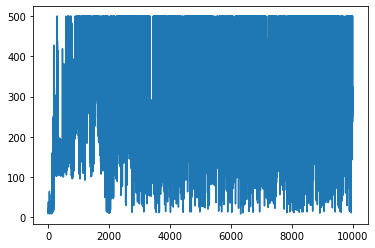

In [20]:
plt.plot(steps_total)
plt.show()

In [21]:
print("Average number of steps: {}". format(np.average(steps_total)))

Average number of steps: 340.1499


In [22]:
print("Average number of steps=reward: {}". format(np.average(steps_total)))
print("Average number of steps=reward in last 100 episodes: {}". format(np.average(steps_total[-100:])))



Average number of steps=reward: 340.1499
Average number of steps=reward in last 100 episodes: 396.67


plt.figure(1,figsize=[12,5])
plt.title("Rewards")
plt.bar(torch.arange(len(rewards_total)), rewards_total,alpha=0.6, color='green')
#plt.plot(rewards_total)
plt.show()

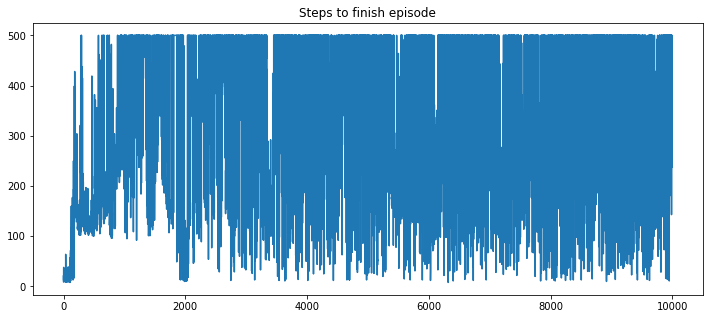

In [23]:
plt.figure(2,figsize=[12,5])
plt.title("Steps to finish episode")
plt.plot(steps_total)
plt.show()